In [1]:
# imports
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import h5py
import matplotlib.pyplot as plt
import cv2

import utilitary as util

In [2]:
hf = h5py.File("../dataset2.h5", "r")

In [3]:
keys = hf.keys()
use_key = util.remove_empty_key(hf, keys)

#removes entries with 1 contour (impossible to rotate atm)
del use_key[184]
del use_key[459]

x,y,z = hf.get('0')['frame'][0].shape
       
nb_entries = len(use_key) 
list_keys = list(use_key)

In [4]:
#Visualisation
#MIP the red channel
r_MIP = util.single_MIP(hf, list_keys[:50], axis = 2, channel=0)

#contours of the red channel
MIP_ctr, _, ctr_list = util.find_contour(r_MIP,0.8,blur=5)

#pick some random img to preprocess
i=5
j=5
idx= np.random.randint(0,50,i*j)

#rotated image and rotated contour
bi_rot = [
    util.rot_img(r_MIP[i], 
                 MIP_ctr[i],
                 ctr_list[i]) for i in idx
]

#contain the image cropped around the contour center of mass
plots = [
    util.crop_ctr_mass(
    bi_rot[i][0],
    bi_rot[i][1]
    ) for i in range(len(idx))
]

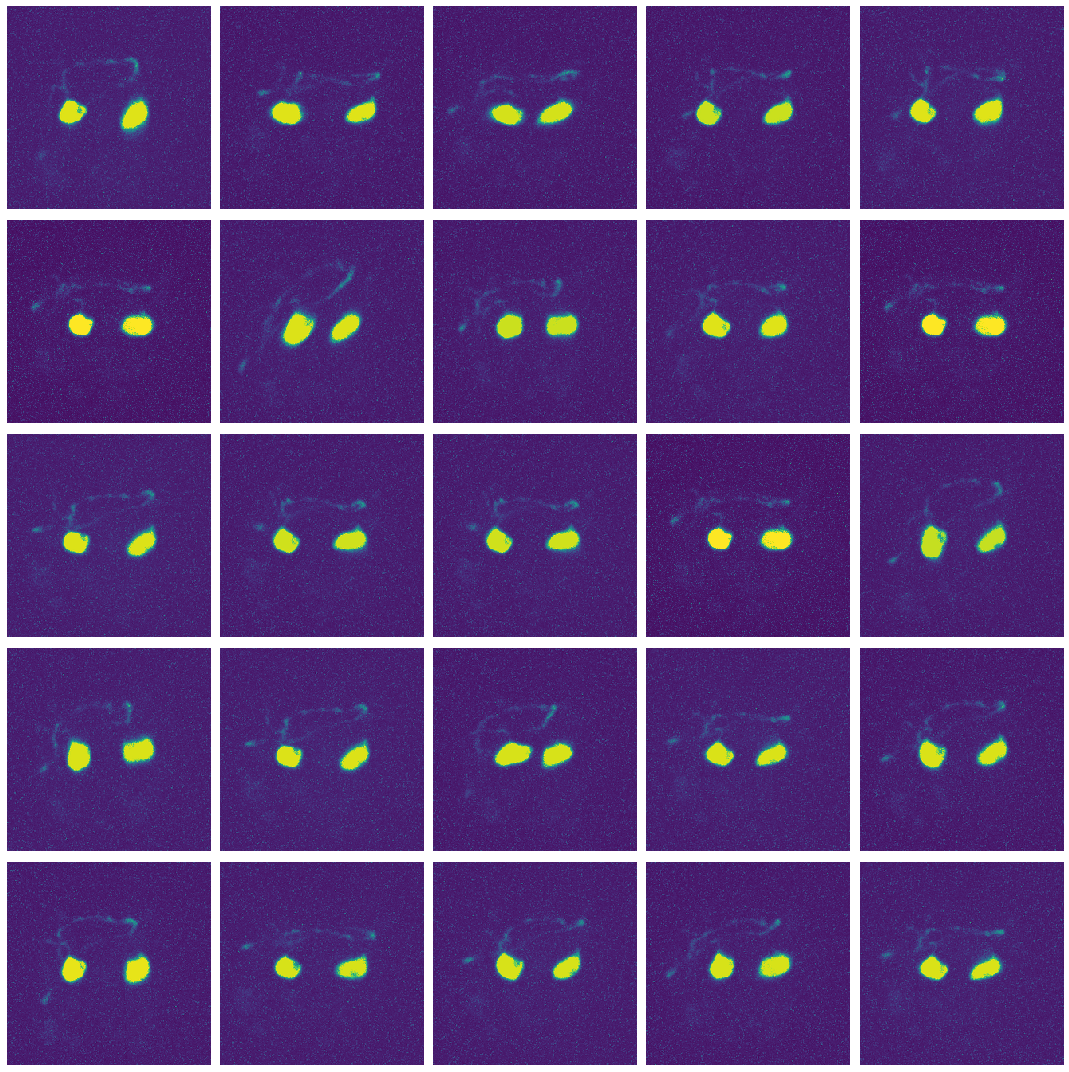

In [5]:
ne.plot.slices(plots, do_colorbars=True, grid = [i,j]);

In [4]:
# Find the mask of every frame of the red channel
masks_red = np.empty((len(use_key), x, y, z), dtype=np.int8)

for i, key in enumerate(use_key):
    a = hf.get(key)['frame'][0]
    a = cv2.medianBlur(a, 5)
    masks_red[i] = np.where(a > 130, 1, 0)

In [5]:
# Apply the mask on the green channel
g_masked = np.zeros((len(use_key), x, y, z), dtype=np.int16)

for i, key in enumerate(use_key):
    a = hf.get(key)['frame'][1]
    a = cv2.medianBlur(a, 5)
    g_masked[i] = np.multiply(a, masks_red[i])

In [6]:
#MIP the red channel
r_MIP, _ = util.MIP_GR(hf, list_keys, axis = 2)
g_MIP = util.np_MIP(g_masked, list_keys, axis=2)

#contours of the red channel
MIP_ctr, _, ctr_list = util.find_contour(r_MIP,0.8,blur=5)

In [7]:
# Save the MIP to avoid loosing 2mn30 each time
np.save('red.npy', r_MIP)
np.save('green.npy', g_MIP)
np.save('mask.npy', masks_red)

In [8]:
r_MIP = np.load('red.npy')
g_MIP = np.load('green.npy')

In [9]:
# indentify img with less than 2 contours
for k, l in enumerate(ctr_list):
    if len(l) < 2:
        print (k)

In [10]:
#rotated image and rotated contour
rotated_img = [
    util.rot_img(r_MIP[i], 
                 MIP_ctr[i],
                 ctr_list[i]) for i in range(len(list_keys))
    ]

rotated_gr = [
    util.rot_img(g_MIP[i], 
                 MIP_ctr[i],
                 ctr_list[i]) for i in range(len(list_keys))
    ]

#contain the image cropped around the contour center of mass
cropped_img = [
    util.crop_ctr_mass(
                        rotated_img[i][0],
                        rotated_img[i][1]
                    ) for i in range(len(list_keys))
    ]

cropped_gre = [
    util.crop_ctr_mass(
                        rotated_gr[i][0],
                        rotated_img[i][1]
                    ) for i in range(len(list_keys))
    ]

In [11]:
# Split train-validation set
# 80% train - 20% validation
ratio = 0.8
keys_random = np.random.permutation(nb_entries)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]

In [12]:
# generate train and test set on cropped rotated img
slices_train = np.array([cropped_img[i] for i in keys_train])
slices_test  = np.array([cropped_img[i] for i in keys_test])
slices_test_gr  = np.array([cropped_gre[i] for i in keys_test])

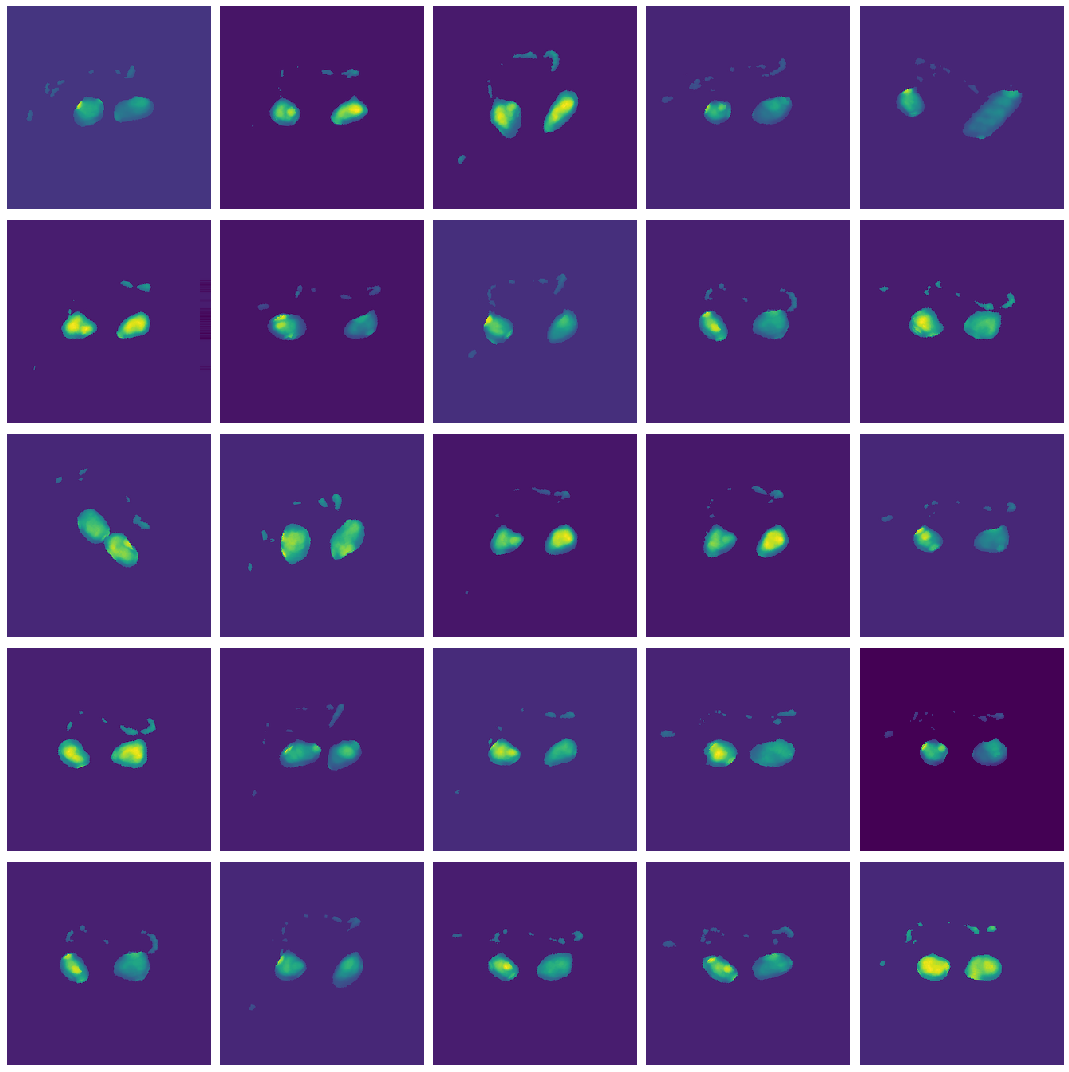

In [28]:
#have a look at some random entries
j, i = 5, 5
idx= np.random.randint(0,114,i*j)
ne.plot.slices([slices_test_gr[i] for i in idx], do_colorbars=True, grid = [i,j]);

In [23]:
# UNET architecture

vol_shape = slices_train[0].shape
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

Instructions for updating:
Use fn_output_signature instead


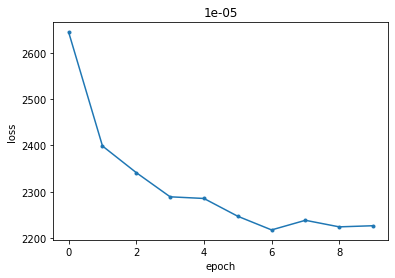

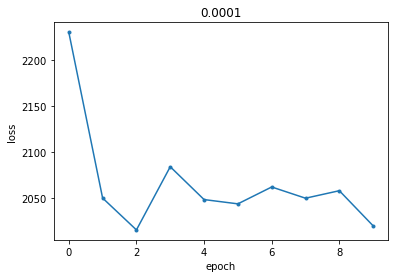

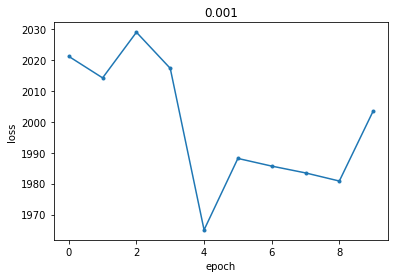

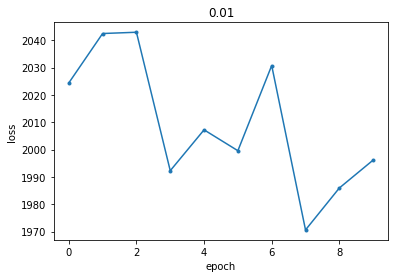

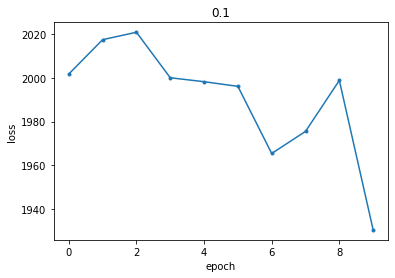

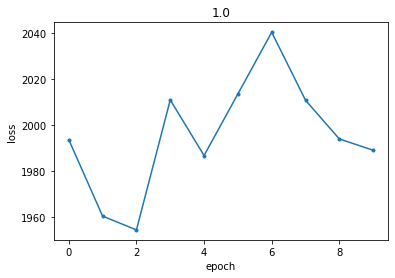

In [18]:

# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-5,0,6)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
#     vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=2)
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = util.vxm_data_generator(slices_train, 12, batch_size = 32)
    hist = vxm_model.fit(train_generator, epochs=10, steps_per_epoch= 100, verbose=0);
    # Visualize the losses
    util.plot_history(hist, save_name = str(lambda_))
    title = "w_rotcrop" + str(lambda_) + ".keras"
    # If it looks ok => save the weights
    vxm_model.save_weights(title)

In [24]:
### RED CANAL

# Regularizer
lambdas = np.logspace(-5,0,6)
# Load the best weights found
title = "w_rotcrop" + str(lambdas[-2]) + ".keras"
vxm_model.load_weights(title)

# Validation set generator
val_generator = util.vxm_data_generator(slices_test, 12, batch_size = 15)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

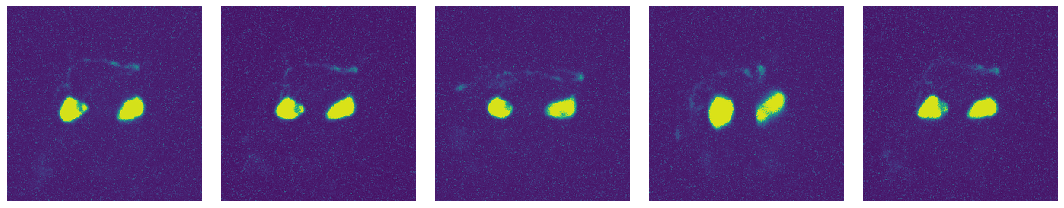

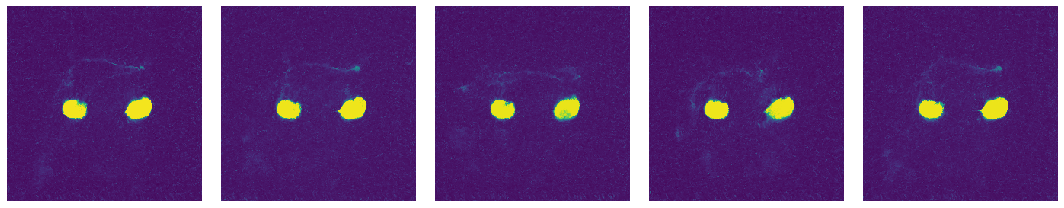

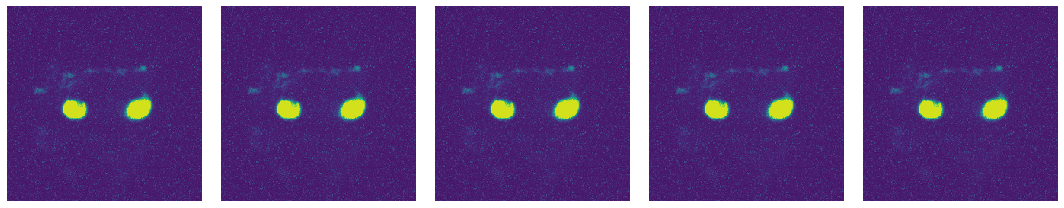

In [25]:
moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]
c = [fixed[i, ...] for i in range(5)]


# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);
# Fixed
ne.plot.slices(c, do_colorbars=True);

In [29]:
###GREEN CANAL

# Load the best weights found
title = "w_rotcrop" + str(lambdas[-2]) + ".keras"
vxm_model.load_weights(title)

# Validation set generator
val_generator = util.vxm_data_generator(slices_test_gr, 12, batch_size = 15)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

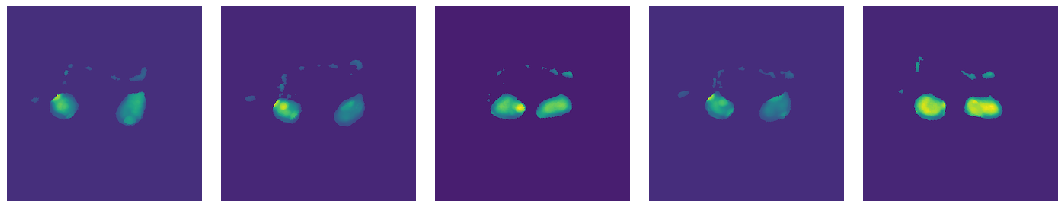

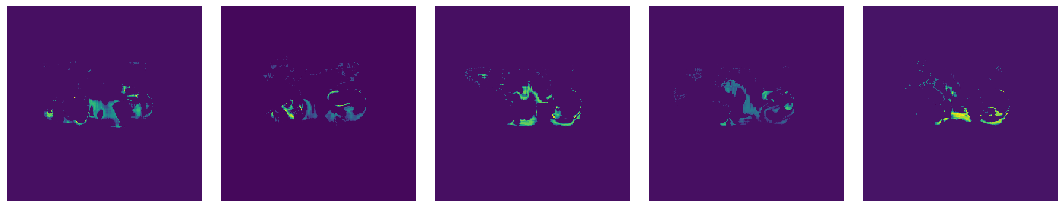

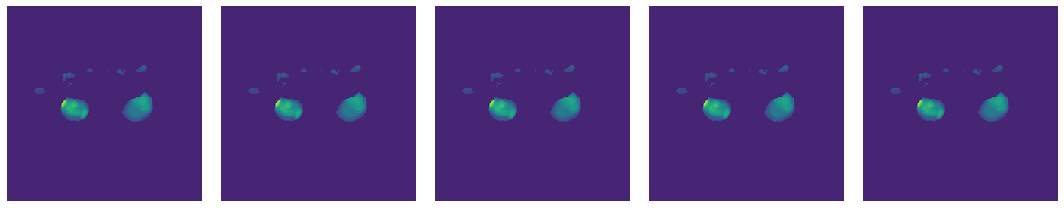

In [30]:
moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]
c = [fixed[i, ...] for i in range(5)]


# Moving
ne.plot.slices(b, do_colorbars=True);
# Moved
ne.plot.slices(a, do_colorbars=True);
# Fixed
ne.plot.slices(c, do_colorbars=True);